In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [34]:
# Load the data
file_path = 'water-consumption-in-the-new-york-city.csv'
data = pd.read_csv(file_path)

In [35]:
# Extract relevant columns
forecast_data = data[['Year', 'NYC Consumption(Million gallons per day)']].set_index('Year')

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(forecast_data)

In [36]:
# Function to create a dataset suitable for LSTM training
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [37]:
# Define the look_back period
look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [38]:
# LSTM model creation function to accept input_shape
def create_lstm_model(units=50, dropout_rate=0.2, input_shape=(1,1)):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [39]:
# Define hyperparameters to tune
units_options = [50, 100]
dropout_options = [0.1, 0.3]
batch_sizes = [10, 25]
epochs_options = [10, 300]

# Placeholder for the best model and its performance
best_model = None
best_performance = float('inf')
best_params = {}

# Iterate over all combinations of hyperparameters
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_sizes:
            for epochs in epochs_options:
                # Create and train the model
                model = create_lstm_model(units, dropout_rate, (X_train.shape[1], 1))
                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                # Evaluate the model
                performance = model.evaluate(X_test, y_test, verbose=0)

                # Update the best model if current model is better
                if performance < best_performance:
                    best_performance = performance
                    best_model = model
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'epochs': epochs}

print("Best Model Parameters:", best_params)
print("Best Model Performance:", best_performance)

Best Model Parameters: {'units': 50, 'dropout_rate': 0.3, 'batch_size': 25, 'epochs': 300}
Best Model Performance: 0.00022265868028625846


The performance metric is quite low, which suggests that the model is performing well on the test data.

In [40]:
# Generate predictions
predicted = best_model.predict(X_test)

# Inverse transform predictions and actual values
predicted_inverse = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for visualization
results = pd.DataFrame({
    'Actual': actual_inverse.flatten(),
    'Predicted': predicted_inverse.flatten()
})

1/1 [==============================] - 0s 382ms/step


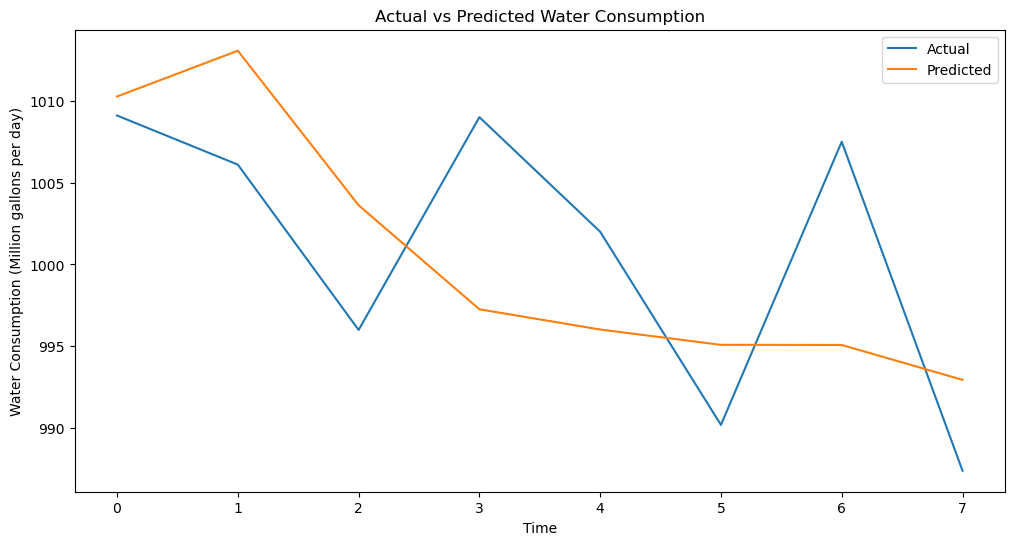

In [41]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Water Consumption')
plt.xlabel('Time')
plt.ylabel('Water Consumption (Million gallons per day)')
plt.legend()
plt.show()

In [42]:
# Prepare the last known data
input_seq = scaled_data[-look_back:]  # Last 'look_back' years of data
input_seq = np.reshape(input_seq, (1, look_back, 1))

# Forecast the next 5 years
forecasts = []
for i in range(5):  # Forecasting 5 years
    pred = best_model.predict(input_seq)
    forecasts.append(pred[0, 0])  # Store the prediction

    # Update the input sequence for the next prediction
    input_seq = np.append(input_seq[0, 1:, 0], pred).reshape(1, look_back, 1)

# Inverse transform the forecasts to original scale
forecasts_inverse = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Generate the forecast index (years)
forecast_index = range(data['Year'].iloc[-1] + 1, data['Year'].iloc[-1] + 6)

1/1 [==============================] - 0s 26ms/step


In the offical website they added the years 2020 and 2021 (https://www.nyc.gov/site/dep/water/history-of-drought-water-consumption.page)

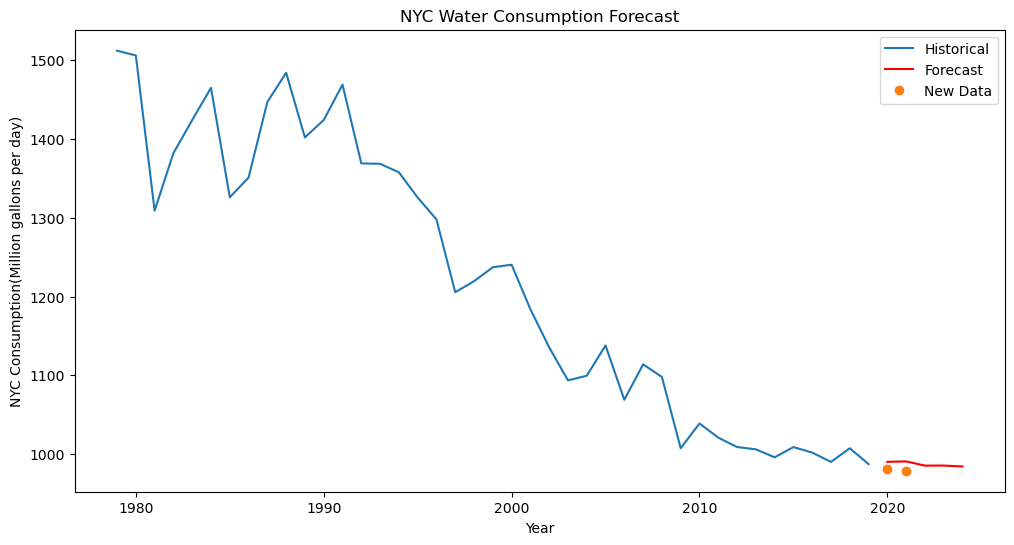

In [43]:
# Plotting the forecast alongside historical data
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['NYC Consumption(Million gallons per day)'], label='Historical')
plt.plot(forecast_index, forecasts_inverse.flatten(), label='Forecast', color='red')

# Plot any new data points
plt.plot([2020,2021],[981.0, 979.0], marker='o', ls='none', label='New Data')

plt.title("NYC Water Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("NYC Consumption(Million gallons per day)")
plt.legend()
plt.show()